In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

import skimage.io as sio

import torch
from torchvision.transforms.functional import center_crop
from torch import nn, optim

from umap import UMAP
from hdbscan import HDBSCAN
import umap.plot as uplt
from lmcontrol.segment import outlier_cluster, trim_box

/Users/ajtritt/anaconda3/envs/sdbr/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ajtritt/anaconda3/envs/sdbr/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/ajtritt/anaconda3/envs/sdbr/lib/python3.11/site-packages/umap/d

In [2]:
base_dir = "/Users/ajtritt/projects/abpdu/bisabolene_CN"

In [7]:
ht_labels = list()
seg_images = list()
seg_masks = list()
paths = list()
for i in range(12):
    image_dir = f"{base_dir}/S4/S4_HT{i+1}"
    print(f"Reading {image_dir}")
    for tif in tqdm(glob.glob(f"{image_dir}/*.tif")):
        image = sio.imread(tif)[:, :, 0]
        try:
            #TODO: Add check for garbage images i.e. overdispersed images.
            if image.std() > 15:
                raise ValueError("StdDev of pixels is quite high, this is probably a bad image")
            mask = outlier_cluster(image)
            segi = trim_box(mask, image)
            segm = trim_box(mask, mask, size=(64,32))
            # if mask.shape[0] < mask.shape[1]:
            #     segi = ndi.rotate(segi, -90)
            #     segm = ndi.rotate(segm, -90)
            seg_images.append(segi)
            seg_masks.append(segm)
            paths.append(tif)    
            ht_labels.append(i)
        except ValueError:
            continue
ht_labels = np.array(ht_labels)

tmp_ht_labels = list()
tmp_seg_images = list()
tmp_seg_masks = list()
tmp_paths = list()
for htl, segi, segm, p in zip(ht_labels, seg_images, seg_masks, paths):
    if segm.shape == (0, 32):
        continue
    tmp_ht_labels.append(htl)
    tmp_seg_images.append(segi)
    tmp_seg_masks.append(segm)
    tmp_paths.append(p)
seg_masks = np.array(tmp_seg_masks)
ht_labels = tmp_ht_labels
seg_images = tmp_seg_images
paths = tmp_paths
seg_masks = np.array(seg_masks).reshape(-1, 2048)

Reading /Users/ajtritt/projects/abpdu/bisabolene_CN/S4/S4_HT1


100%|██████████| 10000/10000 [00:31<00:00, 317.66it/s]


Reading /Users/ajtritt/projects/abpdu/bisabolene_CN/S4/S4_HT2


100%|██████████| 10000/10000 [00:44<00:00, 224.61it/s]


Reading /Users/ajtritt/projects/abpdu/bisabolene_CN/S4/S4_HT3


100%|██████████| 10000/10000 [00:38<00:00, 257.32it/s]


Reading /Users/ajtritt/projects/abpdu/bisabolene_CN/S4/S4_HT4


100%|██████████| 10000/10000 [00:32<00:00, 308.94it/s]


Reading /Users/ajtritt/projects/abpdu/bisabolene_CN/S4/S4_HT5


100%|██████████| 10000/10000 [00:33<00:00, 301.80it/s]


Reading /Users/ajtritt/projects/abpdu/bisabolene_CN/S4/S4_HT6


100%|██████████| 10000/10000 [00:30<00:00, 326.85it/s]


Reading /Users/ajtritt/projects/abpdu/bisabolene_CN/S4/S4_HT7


100%|██████████| 10000/10000 [00:37<00:00, 263.44it/s]


Reading /Users/ajtritt/projects/abpdu/bisabolene_CN/S4/S4_HT8


100%|██████████| 10000/10000 [00:38<00:00, 259.45it/s]


Reading /Users/ajtritt/projects/abpdu/bisabolene_CN/S4/S4_HT9


100%|██████████| 10000/10000 [00:41<00:00, 243.24it/s]


Reading /Users/ajtritt/projects/abpdu/bisabolene_CN/S4/S4_HT10


100%|██████████| 10000/10000 [00:44<00:00, 223.12it/s]


Reading /Users/ajtritt/projects/abpdu/bisabolene_CN/S4/S4_HT11


100%|██████████| 10000/10000 [00:44<00:00, 223.12it/s]


Reading /Users/ajtritt/projects/abpdu/bisabolene_CN/S4/S4_HT12


100%|██████████| 10000/10000 [00:41<00:00, 241.93it/s]


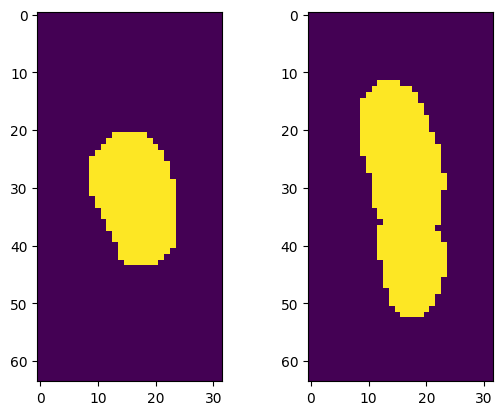

In [8]:
masks = seg_masks.reshape(-1, 64, 32)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(masks[0])
axes[1].imshow(masks[1])

In [9]:
import seaborn as sns
import matplotlib.colors as mpc

def get_color_key(labels, cmap='tab20'):
    ret = {-1: '#000000'}
    uniq = np.unique(labels)
    for l, c in zip(uniq[1:], sns.color_palette(cmap, len(uniq) - 1)):
        ret[l] = mpc.to_hex(c)
    return ret

In [10]:
basic_umap = UMAP(n_components=2, min_dist=0.1, random_state=1001, metric='jaccard')
emb = basic_umap.fit_transform(seg_masks)

/Users/ajtritt/anaconda3/envs/sdbr/lib/python3.11/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


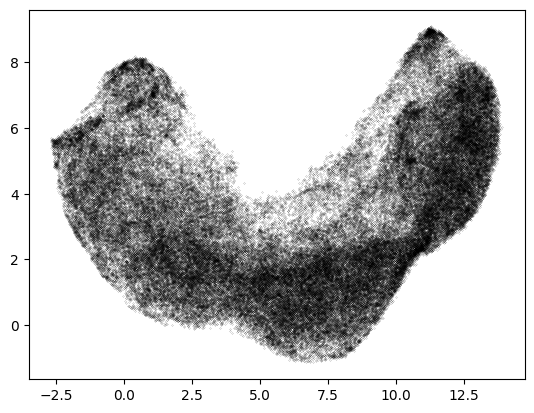

In [11]:
plt.scatter(emb[:, 0], emb[:, 1], s=0.01, color='k')

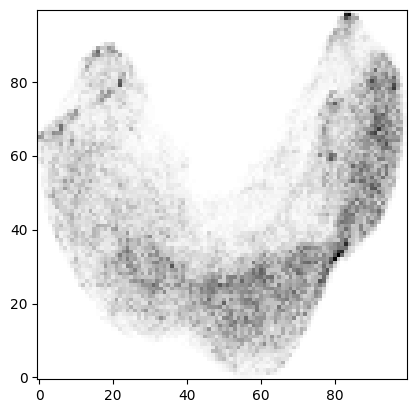

In [12]:
hist, xedge, yedge = np.histogram2d(emb[:, 0], emb[:, 1], bins=100, density=True)
plt.imshow(hist.T, cmap='Greys', origin='lower')

In [13]:
hdbscan = HDBSCAN(algorithm='boruvka_kdtree', min_cluster_size=1000)
hdbscan_labels = hdbscan.fit_predict(emb)

In [14]:
hdbscan_labels.max()

3

<Axes: >

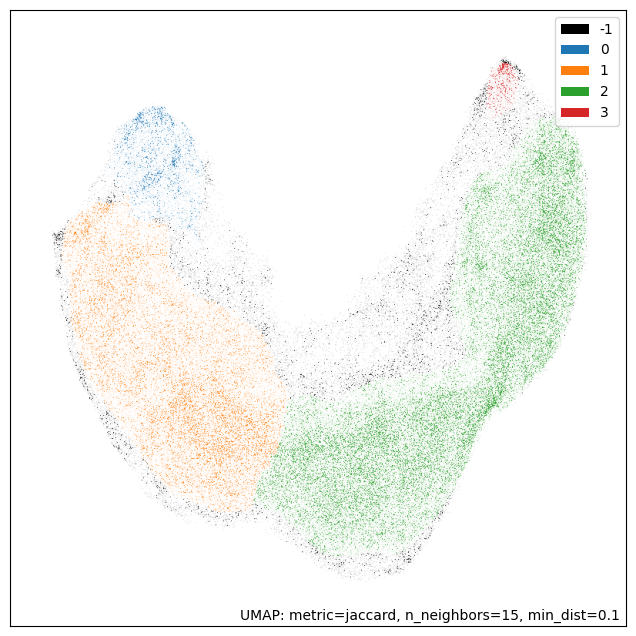

In [16]:
uplt.points(basic_umap, labels=hdbscan_labels, color_key=get_color_key(hdbscan_labels, cmap='tab10'))

In [17]:
mean_images = list()
cluster_mean_pixels = list()
    
for lbl in np.arange(np.max(hdbscan_labels)+1):
    mask = hdbscan_labels == lbl
    mean_images.append(seg_masks[mask].mean(axis=0).reshape(64, 32))
    cluster_mean_pixels.append(seg_masks[mask].mean())

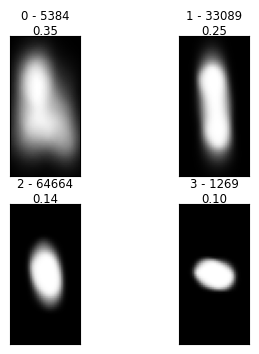

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(4, 4))

for ax in axes.ravel():
    ax.tick_params('both', bottom=False, left=False, labelleft=False, labelbottom=False)

for i, (ax, img, mean) in enumerate(zip(axes.ravel(), mean_images, cluster_mean_pixels)):
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{i} - {(hdbscan_labels == i).sum()}\n{mean:.2f}", fontsize='small', y=0.95)

In [22]:
import shutil
import os
cluster_dir = os.path.join(f"{base_dir}", "S4_seg/mask_clusters")
if os.path.exists(cluster_dir):
    shutil.rmtree(cluster_dir)
os.makedirs(cluster_dir)

for lbl in np.arange(np.max(hdbscan_labels+1)):
    mask = hdbscan_labels == lbl
    directory = os.path.join(cluster_dir, f"cluster_{lbl:02g}")
    os.makedirs(directory)
    for idx in np.where(mask)[0]:
        target = os.path.join(directory, os.path.basename(paths[idx]))
        sio.imsave(target, seg_images[idx])
        

In [69]:
from sklearn.preprocessing import normalize
normed_masks = normalize(seg_masks)

In [71]:
normed_umap = UMAP(n_components=2, min_dist=0.1, random_state=1001, metric='euclidean')
normed_emb = normed_umap.fit_transform(normed_masks)

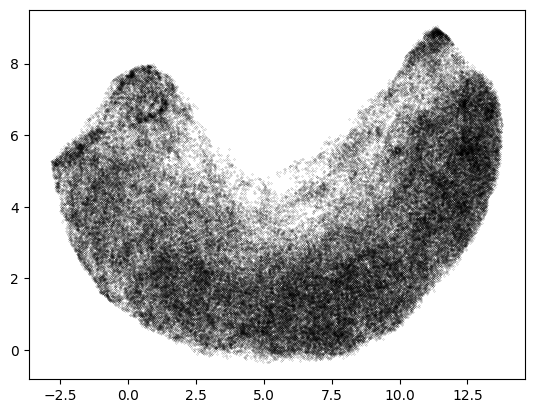

In [72]:
plt.scatter(normed_emb[:, 0], normed_emb[:, 1], s=0.01, color='k')